

In this notebook, I will show first how to concate the TPM and counts across samples and then show how to perform DEG and generate SWAN reports.

## Load library

In [1]:
import pandas as pd
import numpy as np
import anndata as ad
from gtfparse import read_gtf

from utils import *

import warnings
warnings.filterwarnings("ignore")

## Get transcript information

Since kallisto only gives us `trainscript_id`, we need to gather other information such as transcript name or gene id and gene name using GTF. 

In this part, we show how we should do this.

In [2]:
gencode_gtf = read_gtf("data/gencode.vM21.primary_assembly.annotation_UCSC_names.gtf").to_pandas()

gencode_gtf_transcript = gencode_gtf[gencode_gtf["feature"] == "transcript"]
gencode_gtf_transcript = gencode_gtf_transcript[['transcript_id', 
                                                 'transcript_type', 
                                                 'transcript_name', 
                                                 'gene_id', 
                                                 'gene_type', 
                                                 'gene_name']]
gencode_gtf_transcript.index = gencode_gtf_transcript.transcript_id.tolist()
gencode_gtf_transcript

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


,transcript_id,transcript_type,transcript_name,gene_id,gene_type,gene_name
ENSMUST00000193812.1,ENSMUST00000193812.1,TEC,4933401J01Rik-201,ENSMUSG00000102693.1,TEC,4933401J01Rik
ENSMUST00000082908.1,ENSMUST00000082908.1,snRNA,Gm26206-201,ENSMUSG00000064842.1,snRNA,Gm26206
ENSMUST00000162897.1,ENSMUST00000162897.1,processed_transcript,Xkr4-203,ENSMUSG00000051951.5,protein_coding,Xkr4
ENSMUST00000159265.1,ENSMUST00000159265.1,processed_transcript,Xkr4-202,ENSMUSG00000051951.5,protein_coding,Xkr4
ENSMUST00000070533.4,ENSMUST00000070533.4,protein_coding,Xkr4-201,ENSMUSG00000051951.5,protein_coding,Xkr4
...,...,...,...,...,...,...
ENSMUST00000180208.1,ENSMUST00000180208.1,protein_coding,AC133095.2-201,ENSMUSG00000095475.1,protein_coding,AC133095.2
ENSMUST00000178327.1,ENSMUST00000178327.1,protein_coding,AC133095.1-201,ENSMUSG00000094855.1,protein_coding,AC133095.1
ENSMUST00000178569.1,ENSMUST00000178569.1,protein_coding,AC234645.1-201,ENSMUSG00000095019.1,protein_coding,AC234645.1
ENSMUST00000179505.7,ENSMUST00000179505.7,protein_coding,AC149090.1-201,ENSMUSG00000095041.7,protein_coding,AC149090.1


## Concate count and tpm matrices

After we grab transcript information from GTF file and clean it up, it's time to make count and TPM h5ad files in a way that `var` contains information regarding transcript and `obs` contains information about samples.


In [22]:
counts = ad.read_mtx(f'data/output_ad003_12670_lig-blk/matrix.abundance.mtx')
counts.X.toarray()

array([[ 0.     ,  0.     , 14.515  , ...,  0.     ,  0.     , 99.8676 ],
       [ 0.     ,  0.     ,  3.21131, ...,  0.     ,  0.     , 72.313  ]],
      dtype=float32)

In [25]:
counts.obs

""
0
1


In [29]:
adata_count = ad.concat([adata_count, counts], axis=0)

ValueError: Observations annot. `obs` must have as many rows as `X` has rows (4), but has 2 rows.

In [4]:
samples = pd.read_csv("data/sample_name.txt", header=None, sep='   ')[0].tolist()

metadata_sample_path = "data/sample_metadata.csv"

adata_count = None
adata_tpm = None

for sample in samples:
    transcript = pd.read_csv(f'data/output_{sample}/transcripts.txt', header=None, index_col=0)
    transcript.index.names = ['']
    counts = ad.read_mtx(f'data/output_{sample}/matrix.abundance.mtx', dtype='float32')[0]
    counts.obs.index = [sample]
    counts.var.index = transcript.index.tolist()
    
    tpm = ad.read_mtx(f'data/output_{sample}/matrix.abundance.tpm.mtx', dtype='float32')[0]
    tpm.obs.index = [sample]
    tpm.var.index = transcript.index.tolist()

    if adata_count is None:
        adata_count = counts.copy()
        adata_tpm = tpm.copy()
        continue

    adata_count = ad.concat([adata_count, counts], axis=0)
    adata_count.var = pd.concat([adata_count.var, transcript], axis=1).loc[adata_count.var.index, :]
    adata_count.var = pd.concat([adata_count.var, gencode_gtf_transcript], axis=1).loc[adata_count.var.index, :]

    adata_tpm = ad.concat([adata_tpm, tpm], axis=0)
    adata_tpm.var = pd.concat([adata_tpm.var, transcript], axis=1).loc[adata_tpm.var.index, :]
    adata_tpm.var = pd.concat([adata_tpm.var, gencode_gtf_transcript], axis=1).loc[adata_tpm.var.index, :]

metadata_sample = pd.read_csv(metadata_sample_path)
metadata_sample.index = metadata_sample['Sample Name'].values

adata_count.obs = pd.concat([adata_count.obs, metadata_sample], axis=1)
adata_tpm.obs = pd.concat([adata_tpm.obs, metadata_sample], axis=1)


adata_count.write(filename="data/transcript_exp_count.h5ad")
adata_tpm.write(filename="data/transcript_exp_tpm.h5ad")

ValueError: Observations annot. `obs` must have as many rows as `X` has rows (2), but has 1 rows.

## Differential Isoform Expression (DIE) analysis

In this part, you will perform the DIE analysis. Based on the mouse model and comparison they requested, you need to adjust the filtering.

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.51 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 2.71 seconds.

Fitting LFCs...
... done in 1.59 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.06 seconds.



Log2 fold change & Wald test p-value: Genotype 5xCLU-h2kbKI-HO vs 5xFADHEMI
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUST00000070533.4   7.616738       -0.593405  0.579417 -1.024141  0.305769   
ENSMUST00000159265.1   0.331782        0.043846  2.905618  0.015090  0.987960   
ENSMUST00000162897.1   0.333942        0.043846  2.900915  0.015114  0.987941   
ENSMUST00000195335.1   0.163716       -0.917938  4.228848 -0.217066  0.828157   
ENSMUST00000192336.1   1.636390       -4.135863  2.172389 -1.903832  0.056932   
...                         ...             ...       ...       ...       ...   
ENSMUST00000177671.7   0.163716       -0.917938  4.228848 -0.217066  0.828157   
ENSMUST00000179077.1  24.062353       -2.234310  0.545238 -4.097864  0.000042   
ENSMUST00000179483.7  11.780337       -0.493009  0.592329 -0.832322  0.405227   
ENSMUST00000178343.1  17.558881       -0.620590  0.390999 -1.587191  0.112469   
ENSMUST00000179505.7   4.975356  

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 61 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'U', 'V', 'Z', 'a', 'b', 'c', 'd', 'e', 'eight', 'equal', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'k', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'zero']
INFO:fontTools.s

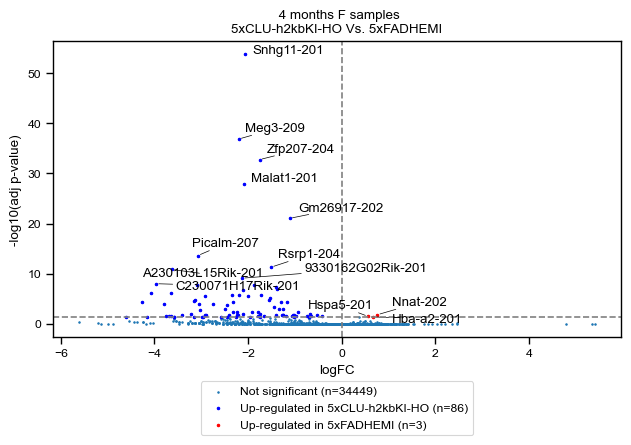

In [2]:
adata_tpm = ad.read_h5ad("data/transcript_exp_tpm.h5ad")
adata_tpm.X = adata_tpm.to_df().apply(pd.to_numeric)

filtering = {'Age': ["4 months"], #c("12mo"),
             'Sex': ["F"], #c("M"),
             'Genotype': ['5xCLU-h2kbKI-HO', '5xFADHEMI']}

if not os.path.exists(f"DIE/"):
    os.makedirs("DIE/", mode=0o777)

fname = f"DIE/{'_'.join(filtering['Genotype'])}_{'_'.join(filtering['Age'])}_{'_'.join(filtering['Sex'])}"

run_deseq2(adata_tpm,
           obs_filtering=filtering,
           obs_condition='Genotype',
           l2fc_thresh=0, 
           adj_p_thresh=0.05,
           label='transcript_name',
           ofile=fname)

## Differential Gene Expression (DGE) analysis

If they also intersted in doing DGE analysis, you first need to calculate the gene expression by summing up the transcript expression for each gene and then adjust the filtering if needed.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.90 seconds.

Fitting dispersion trend curve...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 1.51 seconds.

Fitting LFCs...
... done in 0.85 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.70 seconds.



Log2 fold change & Wald test p-value: Genotype 5xCLU-h2kbKI-HO vs 5xFADHEMI
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000102693.1  28.273763        0.052743  0.309797  0.170250  0.864813   
ENSMUSG00000051951.5   0.997885        0.052788  1.575415  0.033507  0.973270   
ENSMUSG00000103377.1   0.162166       -0.908990  4.016047 -0.226339  0.820937   
ENSMUSG00000104017.1   0.327640       -1.808259  3.045333 -0.593780  0.552659   
ENSMUSG00000103025.1  26.948427        0.123940  0.318423  0.389230  0.697106   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000099643.1  12.159348        0.250688  0.467167  0.536613  0.591535   
ENSMUSG00000101533.1   0.162166       -0.908990  4.016047 -0.226339  0.820937   
ENSMUSG00000100036.1   0.163697       -0.908990  4.004252 -0.227006  0.820419   
ENSMUSG00000099619.6   0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000095366.1   0.171454  

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 60 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'R', 'T', 'U', 'V', 'a', 'b', 'c', 'd', 'e', 'eight', 'equal', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'k', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'zero']
INFO:fontTools.subset

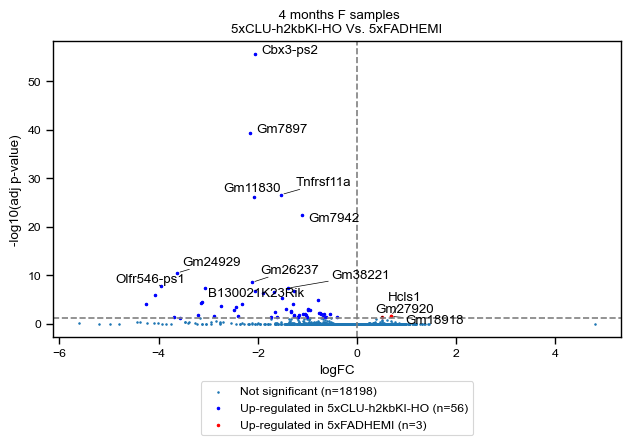

In [28]:
adata_tpm = ad.read_h5ad("data/transcript_exp_tpm.h5ad")
adata_tpm.X = adata_tpm.to_df().apply(pd.to_numeric)

#sum up transcript experssion per genes
df_tpm_gene = adata_tpm.to_df().T.groupby(adata_tpm.var['gene_id']).sum().T
gene_var = adata_tpm.var[['gene_id', 'gene_type', 'gene_name']]
gene_var.index = gene_var.gene_id.tolist()
gene_var.drop_duplicates(inplace=True)
adata_tpm_gene = ad.AnnData(X=df_tpm_gene.values, var=gene_var, obs=adata_tpm.obs)

filtering = {'Age': ["4 months"], #c("12mo"),
             'Sex': ["F"], #c("M"),
             'Genotype': ['5xCLU-h2kbKI-HO', '5xFADHEMI']}

if not os.path.exists(f"DGE/"):
    os.makedirs("DGE/", mode=0o777)

fname = f"DGE/{'_'.join(filtering['Genotype'])}_{'_'.join(filtering['Age'])}_{'_'.join(filtering['Sex'])}"

run_deseq2(adata_tpm_gene,
           obs_filtering=filtering,
           obs_condition='Genotype',
           l2fc_thresh=0, 
           adj_p_thresh=0.05,
           label='gene_name',
           ofile=fname)